In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import pyreadr

from utils import helpers

from importlib import reload

In [2]:
# Load Outfield Data

# Dan Data

outfield_dims = pyreadr.read_r('fences.rds')[None]

outfield_dims['spray_angle'] = outfield_dims.apply(lambda x: helpers.spray_angle(x.x, x.y),1) 

outfield_dims['team_abv'] = outfield_dims['team'].apply(lambda x: helpers.mapping[x])

# Ben Data

new_dims = pd.read_csv('data/mlb_stadia_paths.csv')

team_maps = pd.read_csv('data/team_maps2.csv')

In [3]:
# Load Judge Data, dropping an unneeded column and filtering to just the regular season, also dropping instances where the spray angle isn't available

aj = pd.read_csv('data/Judge2022.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06" and description != "foul"')
aj['true_homerun'] = aj['num_homers'].apply(lambda x: 1 if x == 30 else 0)

def spray_fix(x):
    if x < -45:
        return -44.9
    elif x > 45:
        return 44.9
    else:
        return x
    
aj['spray_angle_true'] = aj['spray_angle_true'].apply(lambda x: spray_fix(x),1)

C:\Users\noahs\AppData\Local\Temp\ipykernel_39664\1788960890.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aj = pd.read_csv('data/Judge2022.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06" and description != "foul"')


In [4]:
# The full dataset

df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06"').query('description != "foul"').reset_index(drop=True)

df_full['true_homerun'] = df_full['num_homers'].apply(lambda x: 1 if x == 30 else 0)

df_full['spray_angle_true'] = df_full['spray_angle_true'].apply(lambda x: spray_fix(x),1)

ids = pd.read_csv('data/players_id.csv')

df_full = df_full.merge(ids[['MLBID','PLAYERNAME']],how='left',left_on='batter',right_on='MLBID')

df_full = df_full.query('PLAYERNAME.notnull()')

df_full.drop_duplicates(inplace=True)

C:\Users\noahs\AppData\Local\Temp\ipykernel_39664\2341426491.py:3: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06"').query('description != "foul"').reset_index(drop=True)
C:\Users\noahs\AppData\Local\Temp\ipykernel_39664\2341426491.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('game_date > "2022-04-07" and game_date < "2022-10-06"').query('description != "foul"').reset_index(drop=True)


In [5]:
# This generates a dataframe that has the number of home runs aaron judge wouldve hit if he played every game as that stadium

hr_count = []
for t in df_full['home_team'].unique():
    hr_count.append(aj[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],t,x[6]),1).sum())

hr_count_by_stadium = pd.DataFrame(zip(df_full['home_team'].unique(), hr_count), columns=['Stadium','HR Count']).sort_values('HR Count',ascending=False).reset_index(drop=True)

hr_count_by_stadium

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: inv

,Stadium,HR Count
0,CIN,70
1,CWS,66
2,PHI,65
3,MIL,65
4,TOR,65
5,NYY,64
6,LAD,63
7,COL,62
8,DET,62
9,CHC,62


c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x


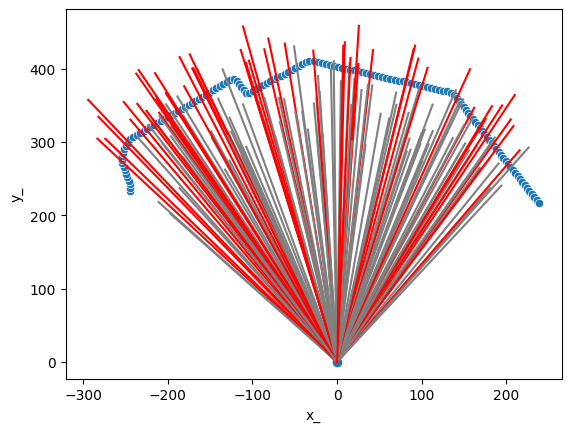

In [24]:
aj['temp_hr'] = aj[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],'BAL',x[6]),1)

sns.scatterplot(data=team_maps.query('team == "BAL"'),x='x_',y='y_')
plt.plot(0,0,marker='o')
for x, y, hr in zip(aj['hc_x_'], aj['hc_y_'],aj['temp_hr']):
    if hr == 0:
        plt.plot([0,x],[0,y],'grey')
    else:
        plt.plot([0,x],[0,y],'red')

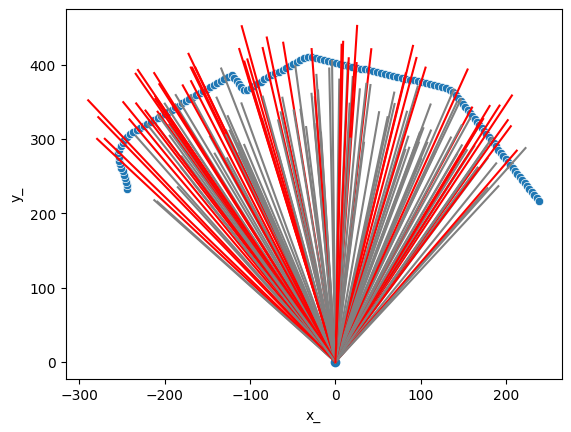

In [26]:
sns.scatterplot(data=team_maps.query('team == "BAL"'),x='x_',y='y_')
plt.plot(0,0,marker='o')

for dist, angle, c in zip(aj['hit_distance_sc'], aj['spray_angle_true'],aj['temp_hr']):
    x = dist * np.cos(np.deg2rad(angle * -1)) 
    y = dist * np.sin(np.deg2rad(angle * -1))
    
    x_rotated = -y
    y_rotated = x
    
    if c == 0:
        plt.plot([0, x_rotated], [0, y_rotated], c='grey')
    else:
        plt.plot([0,x_rotated],[0,y_rotated],c='red')


In [9]:
# Scheduling data and function

reload(helpers)

sched = pd.read_csv('data/mlb_sched.csv')

sched['Stadium'] = sched['Field'].apply(lambda x: helpers.sched_maps[x])
sched['Tm'] = sched['Tm'].apply(lambda x: helpers.sched_maps[x])

def judge_sched(team, mlb_sched, judge_game_map):
    team_sched = mlb_sched[mlb_sched['Tm']==team]
    judge_game_map = judge_game_map.merge(team_sched[['Game_Num','Stadium']],left_on='Game_Num',right_on='Game_Num')
    return judge_game_map

In [10]:
aj = aj.merge(pd.read_csv('data/judge_hit_map.csv')[['game_date','hc_x','hc_y','launch_angle','Game_Num']], left_on=['game_date','hc_x','hc_y','launch_angle'], right_on=['game_date','hc_x','hc_y','launch_angle'], how='left')

In [110]:
judge_sched('SD',sched, aj)[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','Stadium','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]),1).sum()


launch_speed_fts     0.0
launch_angle_rads    0.0
plate_z              0.0
hit_distance_sc      0.0
spray_angle_true     0.0
home_team            0.0
Stadium              0.0
events               0.0
dtype: float64

In [11]:
team_count = []

for team in df_full['home_team'].unique():
    val = judge_sched(team,sched, aj)[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','Stadium','events']].apply(lambda x: helpers.is_home_run_new_team(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]),1).sum()
    team_count.append(val)

hr_count_by_team_sched = pd.DataFrame(zip(df_full['home_team'].unique(), team_count), columns=['Team','HR Count']).sort_values('HR Count',ascending=False).reset_index(drop=True)

hr_count_by_team_sched

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:331: RuntimeWarning: inv

,Team,HR Count
0,CIN,66
1,LAD,64
2,CWS,64
3,CLE,63
4,COL,62
5,MIN,62
6,TB,62
7,KC,62
8,DET,62
9,NYY,62


In [30]:
hr_count_by_team_sched.assign(Diff=lambda x: x['HR Count'] - 62)

,Team,HR Count,Diff
0,CIN,66,4
1,LAD,64,2
2,CWS,64,2
3,CLE,63,1
4,COL,62,0
5,MIN,62,0
6,TB,62,0
7,KC,62,0
8,DET,62,0
9,NYY,62,0


In [27]:
hr_count_by_stadium.columns = ['Team','HR_Count']

In [28]:
hr_count_by_stadium.to_csv("data/hr_stad.csv")

In [12]:
# True Homerun counts

reload(helpers)

aj['num_homers'] = aj[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.num_homers(x[0],x[1],x[2],x[3],x[4],x[5],x[6]),1)

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:290: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x


In [13]:
vals = pd.DataFrame(aj.query('events == "home_run"')['num_homers'].value_counts().reset_index())

print(f"Number of HRs that were only a HR at Yankee Stadium: {vals.query('index == 1')['num_homers'].item()}")
print(f"Number of HRs that were a HR at half the stadiums: {vals.query('index >= 15')['num_homers'].sum()}")
print(f"Number of HRs that were only a HR at every stadium: {vals.query('index == 30')['num_homers'].item()}")


Number of HRs that were only a HR at Yankee Stadium: 1
Number of HRs that were a HR at half the stadiums: 59
Number of HRs that were only a HR at every stadium: 37


In [14]:
vals = pd.DataFrame(aj.query('events != "home_run"')['num_homers'].value_counts().reset_index())

print(f"Number of non-HR hits that would have been a homer somewhere: {vals.query('index >= 1')['num_homers'].sum()}")
print(f"Number of non-HR hits that would have been a HR at half the stadiums: {vals.query('index >= 15')['num_homers'].sum()}")

Number of non-HR hits that would have been a homer somewhere: 16
Number of non-HR hits that would have been a HR at half the stadiums: 3


In [21]:
df_full['hr'] = df_full['events'].apply(lambda x: 1 if x == 'home_run' else 0)

In [17]:
top15 = df_full.groupby('PLAYERNAME').agg(home_runs=('hr', 'sum')).reset_index().sort_values('home_runs',ascending=False).head(15)

In [18]:
# The full dataset

df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('description != "foul"').reset_index(drop=True)

df_full['true_homerun'] = df_full['num_homers'].apply(lambda x: 1 if x == 30 else 0)

df_full['spray_angle_true'] = df_full['spray_angle_true'].apply(lambda x: spray_fix(x),1)

ids = pd.read_csv('data/players_id.csv')

df_full = df_full.merge(ids[['MLBID','PLAYERNAME']],how='left',left_on='batter',right_on='MLBID')

df_full = df_full.query('PLAYERNAME.notnull()')

df_full.drop_duplicates(inplace=True)

C:\Users\noahs\AppData\Local\Temp\ipykernel_39664\1459559201.py:3: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('description != "foul"').reset_index(drop=True)
C:\Users\noahs\AppData\Local\Temp\ipykernel_39664\1459559201.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_full = pd.read_csv('data/hits_output.csv').drop('Unnamed: 0',1).query('description != "foul"').reset_index(drop=True)


In [19]:
df_full.query('game_type == "R"',inplace=True)

In [22]:
top500 = df_full.groupby(['PLAYERNAME','game_year']).agg(home_runs=('hr', 'sum')).reset_index().sort_values('home_runs',ascending=False).head(500)

In [ ]:
top500

,PLAYERNAME,game_year,home_runs
45,Aaron Judge,2022,62
2048,Giancarlo Stanton,2017,59
4528,Pete Alonso,2019,53
3889,Matt Olson,2023,53
40,Aaron Judge,2017,50
...,...,...,...
5391,Trevor Story,2017,24
5663,Willy Adames,2023,24
416,Anthony Rendon,2017,24
4735,Roberto Perez,2019,24


In [320]:
top500dict = {}

for player, year in zip(top500['PLAYERNAME'],top500['game_year']):
    temp = df_full.query(f'PLAYERNAME == "{player}" and game_year == {year}')
    temp['num_hr'] = temp[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team','events']].apply(lambda x: helpers.num_homers(x[0],x[1],x[2],x[3],x[4],x[5],x[6]),1)
    key = player + ',' + str(year)
    top500dict[key] = len(temp.query('events == "home_run" and num_hr == 30'))

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:290: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\noahs\AppData\Local\Temp\ipykernel_29992\4229480362.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\noahs\Documents\Projects\YouTube-Code\utils\helpers.py:290: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\noahs\AppData\Local\Temp\ipykernel_29992\4229480362.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\noahs\Documents\Projects\YouTube-Co

In [339]:
truehrs = pd.DataFrame.from_dict(top500dict, orient='index').reset_index().rename(columns={'index':'PLAYERNAME',0:'True_HR'})

In [345]:
truehrs

,PLAYERNAME,True_HR,game_year
0,Aaron Judge,37,2022
1,Giancarlo Stanton,24,2017
2,Pete Alonso,19,2019
3,Matt Olson,23,2023
4,Aaron Judge,22,2017
...,...,...,...
495,Trevor Story,5,2017
496,Willy Adames,5,2023
497,Anthony Rendon,12,2017
498,Roberto Perez,8,2019


In [348]:
top500 = top500.merge(truehrs,on=['PLAYERNAME','game_year'],how='left').assign(Perc = lambda x: round(x['True_HR'] / x['home_runs'],3))

In [341]:
truehrs['game_year'] = truehrs['PLAYERNAME'].apply(lambda x: x.split(',')[1])
truehrs['PLAYERNAME'] = truehrs['PLAYERNAME'].apply(lambda x: x.split(',')[0])

In [342]:
truehrs['game_year'] = truehrs['game_year'].astype(int)

In [366]:
top500.to_csv('data/top500.csv')

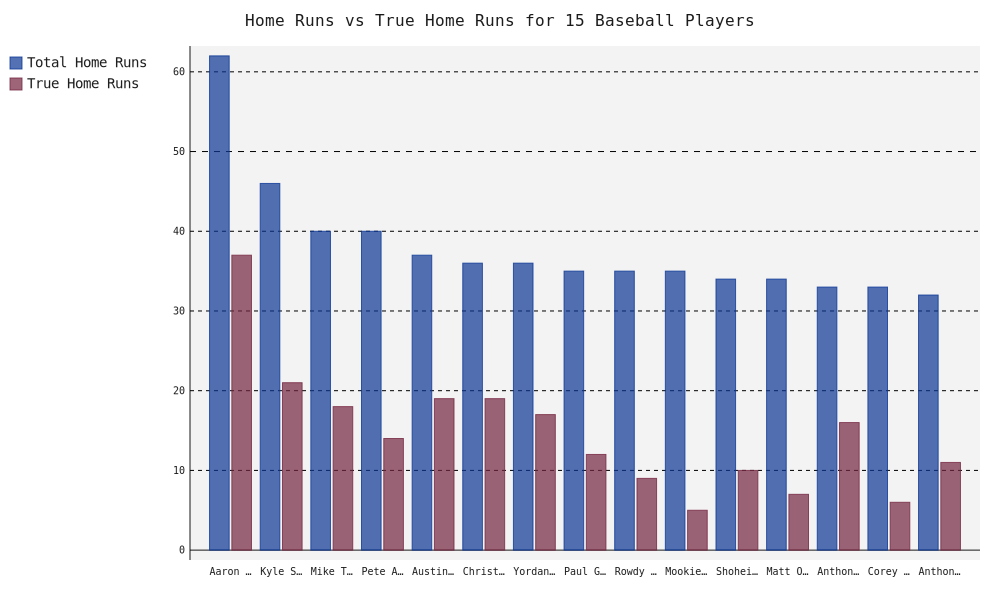

In [287]:
import pygal
from pygal.style import CleanStyle
from IPython.display import display, SVG

# Create a new bar chart with custom style
bar_chart = pygal.Bar(style=CleanStyle, width=1000, height=600)
bar_chart.title = 'Home Runs vs True Home Runs for 15 Baseball Players'

# Setting up the x labels (Player names)
bar_chart.x_labels = top15['PLAYERNAME']

# Adding data series-by-series
bar_chart.add('Total Home Runs', top15['home_runs'].tolist())
bar_chart.add('True Home Runs', top15['True_HR'].tolist())

# Display the SVG in Jupyter Notebook
display(SVG(bar_chart.render()))